In [2]:
## setup code for parsing arguments in my scripts
import argparse
from pathlib import Path
import sys

def main():
    parser = argparse.ArgumentParser(
        description="Extract phonation features from audio files."
    )
    parser.add_argument("input_path", type=Path, help="Path to audio file or folder")
    parser.add_argument("output_file", type=Path, help="Path to output feature file")
    parser.add_argument("static", type=str, help="Static features: 'true' or 'false'")
    parser.add_argument("plots", type=str, help="Plot results: 'true' or 'false'")
    parser.add_argument("format", type=str, choices=["csv", "txt", "npy", "kaldi", "torch"],
                        help="Output file format")

    args = parser.parse_args()

    input_path = args.input_path
    output_file = args.output_file
    static = args.static.lower() == 'true'
    plots = args.plots.lower() == 'true' 
    output_format = args.format

    # Input validation and handling
    if input_path.is_dir() or input_path.is_file():
        print(f"Processing {input_path}")
    else:
        print(f"Input path does not exist {input_path}")
        sys.exit(1)

    print(f"Output stored at {output_file}")
    print(f"Static {static}")
    print(f"Generate plots {plots}")
    print(f"Output format {output_format}")

if __name__ == "__main__":
    main()


usage: ipykernel_launcher.py [-h]
                             input_path output_file static plots
                             {csv,txt,npy,kaldi,torch}
ipykernel_launcher.py: error: the following arguments are required: input_path, output_file, static, plots, format


SystemExit: 2

/home/dene/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


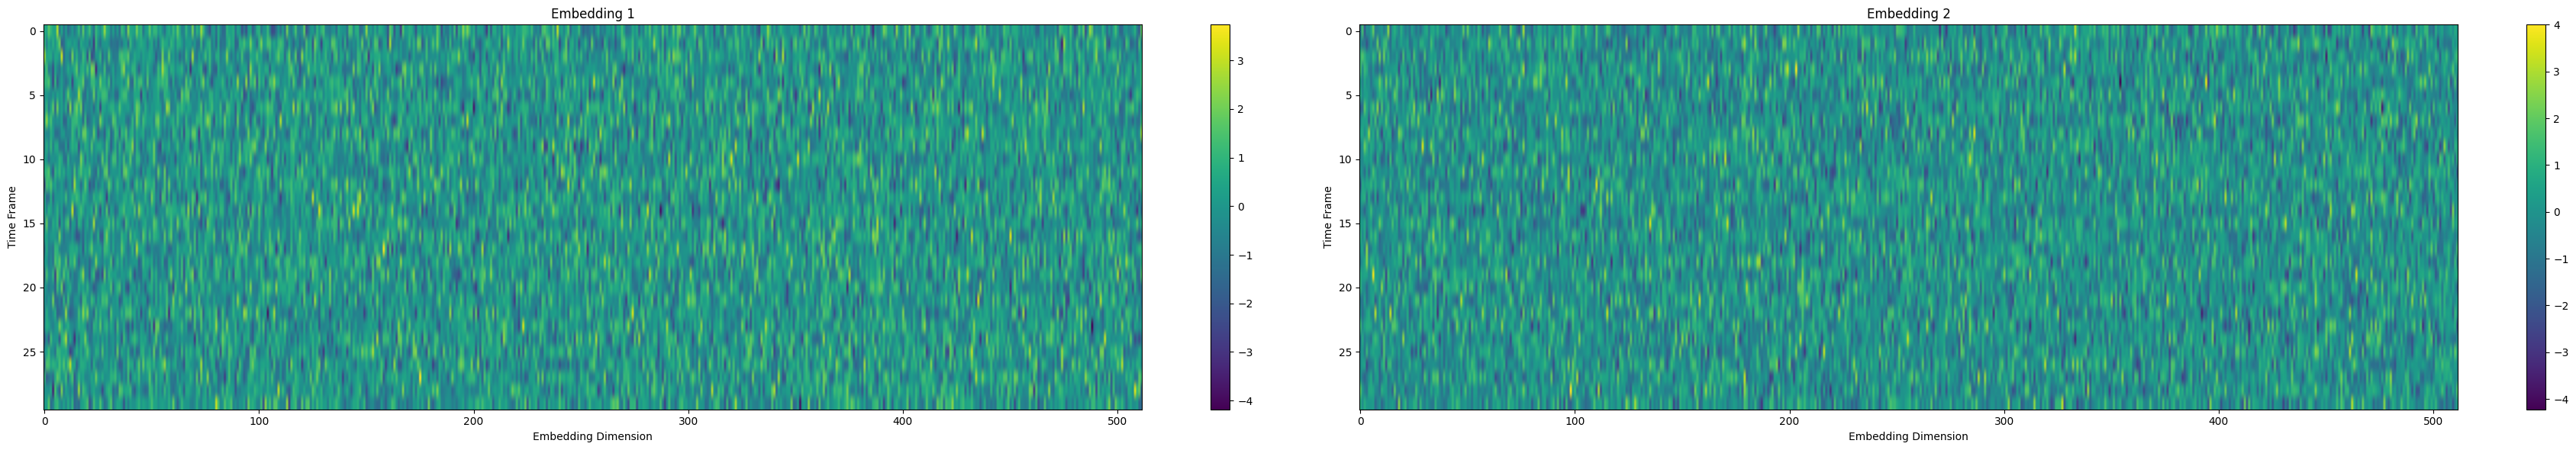

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

embedding1 = np.random.randn(30, 512)
embedding2 = np.random.randn(30, 512)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(36, 6))

im1 = axes[0].imshow(embedding1, aspect='auto', cmap='viridis')
axes[0].set_title("Embedding 1")
axes[0].set_xlabel("Embedding Dimension")
axes[0].set_ylabel("Time Frame")
fig.colorbar(im1, ax=axes[0])

# Heatmap for embedding 2
im2 = axes[1].imshow(embedding2, aspect='auto', cmap='viridis')
axes[1].set_title("Embedding 2")
axes[1].set_xlabel("Embedding Dimension")
axes[1].set_ylabel("Time Frame")
fig.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

In [ ]:
def bland_altman_stats(x, y):
    mean = (x + y) / 2
    diff = x - y
    bias = diff.mean()
    loa = 1.96 * diff.std()
    return mean, diff, bias, bias - loa, bias + loa

def bland_altman_plot(mean, diff, bias, lower, upper, label, ax):
    ax.scatter(mean, diff, alpha=0.5, s=10)
    ax.axhline(bias, color='red', linestyle='--', label='Bias')
    ax.axhline(lower, color='gray', linestyle='--', label='LoA ±1.96 SD')
    ax.axhline(upper, color='gray', linestyle='--')
    ax.set_title(label)
    ax.set_xlabel('Mean of Pair')
    ax.set_ylabel('Difference')
    ax.legend()

def plot_all_pairs(df, feature_cols, exercise):
    mic_pairs = [(1, 2), (2, 3), (1, 3)]
    normalized_df = zscore_normalize(df, feature_cols)
    for feature in feature_cols:
        fig, axes = plt.subplots(1, len(mic_pairs), figsize=(6 * len(mic_pairs), 5))
        if len(mic_pairs) == 1:
            axes = [axes]
        for (mic1, mic2), ax in zip(mic_pairs, axes):
            x = normalized_df[normalized_df['mic'] == mic1][feature].values
            y = normalized_df[normalized_df['mic'] == mic2][feature].values
            min_len = min(len(x), len(y))
            x = x[:min_len]
            y = y[:min_len]
            mean, diff, bias, lower, upper = bland_altman_stats(x, y)
            bland_altman_plot(mean, diff, bias, lower, upper, f'{feature}: Mic {mic1} & {mic2}', ax)
        plt.tight_layout()
        plt.savefig(plots_dir / f'bland_altman_{exercise}_{mic1}_{mic2}.png')
        plt.show()
    
    
def compute_snr_per_feature(df, feature_cols, mic_col='mic', subject_col='subject'):
    snr_dict = {}
    
    for mic in df[mic_col].unique():
        mic_df = df[df[mic_col] == mic]
        snr_dict[mic] = {}
        
        for feature in feature_cols:
            grouped = mic_df.groupby(subject_col)[feature]
            subject_means = grouped.mean()
            signal_var = subject_means.var()
            within_var = grouped.apply(lambda x: x.var()).mean()
            
            snr = signal_var / within_var if within_var > 0 else float('inf')
            snr_dict[mic][feature] = snr

    return pd.DataFrame(snr_dict)

In [ ]:
# delta_dict[mic] = abs_y.reset_index(drop=True)
# mic1_df = id_df[id_df['mic'] == 1].copy()
# mic1_y = mic1_df[y_value].reset_index(drop=True)

# if 2 in delta_dict:
#     delta_to_1_mic2 = np.abs(delta_dict[2] - mic1_y)
#     print("Delta of Clip-on mic to Studio mic for each feature:\n", delta_to_1_mic2)
# if 3 in delta_dict:
#     delta_to_1_mic3 = np.abs(delta_dict[3] - mic1_y)
#     print("Delta of Smartphone mic to Studio mic for each feature:\n", delta_to_1_mic3)